# ATMS 391: Geophysical Data Analysis
## Homework 12
---


(1) Recreate Figure 1 from Horel and Wallace (1981) using the NCEP reanalysis data.

In [47]:
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
import xray
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [48]:
sstdata=xray.open_dataset('sst_seas_ncep.nc')
sstdata

<xray.Dataset>
Dimensions:  (lat: 94, lon: 192, time: 272)
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) datetime64[ns] 1948-02-29 1948-05-31 1948-08-31 ...
Data variables:
    skt      (time, lat, lon) float32 -38.5333 -38.5388 -38.5811 -38.6714 ...

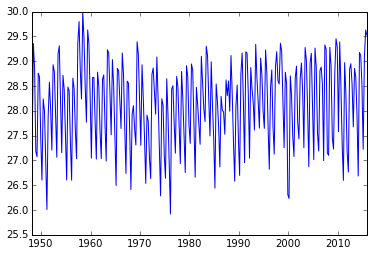

In [49]:

#find time series at point nearest to 10N and 95W
tser=sstdata.sel(lat=[10.],lon=[360.-95.],method='nearest')
tser

plt.figure()
plt.plot(tser['time'].values,tser['skt'].values.ravel())
#sst_resample



In [50]:
ls=xray.open_dataset('lsmask.19294.nc',decode_times=False)
ls['lsmask']

<xray.DataArray 'lsmask' (time: 1, lat: 94, lon: 192)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) float64 -1.577e+07
Attributes:
    long_name: Surface land/sea mask
    valid_range: [-1.  1.]
    actual_range: [-1.  0.]
    units: none
    precision: 2
    var_desc: Land/Sea Mask
    level_desc: Surface
    statistic: Individual Obs
    parent_stat: Other
    dataset: NCEP Reanalysis Derived Products

<matplotlib.colorbar.Colorbar instance at 0x7f26de2f3200>

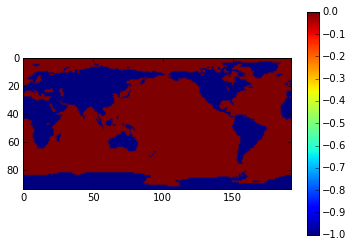

In [51]:
plt.figure()
plt.imshow(ls['lsmask'].values[0,:,:])
plt.colorbar()

In [52]:
mask3d=ls['lsmask'].values.repeat(272,0)
np.shape(mask3d)

(272, 94, 192)

In [53]:
sstdata

<xray.Dataset>
Dimensions:  (lat: 94, lon: 192, time: 272)
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) datetime64[ns] 1948-02-29 1948-05-31 1948-08-31 ...
Data variables:
    skt      (time, lat, lon) float32 -38.5333 -38.5388 -38.5811 -38.6714 ...

<matplotlib.colorbar.Colorbar instance at 0x7f26de08af80>

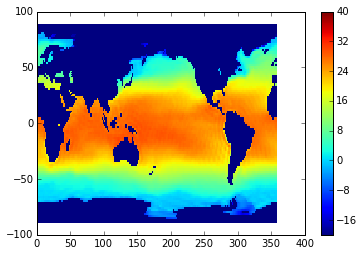

In [54]:
sstdata['skt'].values=np.ma.masked_where(mask3d == -1, sstdata['skt'].values)

plt.figure()
plt.pcolormesh(sstdata['lon'].values,sstdata['lat'].values,sstdata['skt'].values[0,:,:])
plt.clim([-20,40])
plt.colorbar()

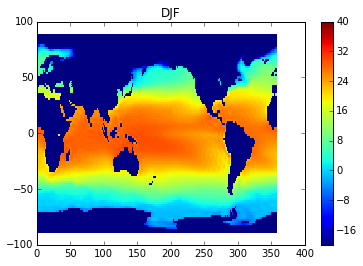

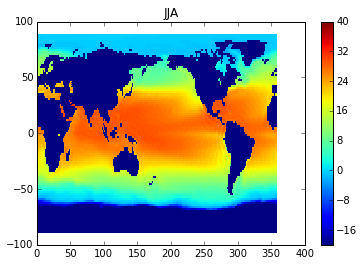

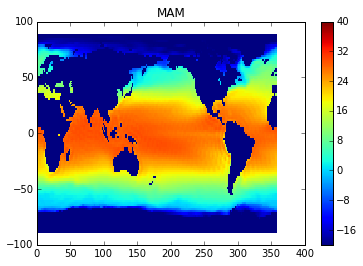

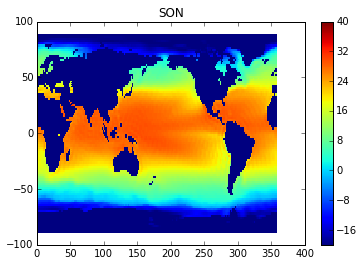

In [55]:
#calculate seasonal  climatology .resample('Q-NOV', 'time',how='mean')

sstseas=sstdata.groupby('time.season').mean(dim='time')


for i in np.arange(4):
    plt.figure()
    plt.pcolormesh(sstdata['lon'].values,sstdata['lat'].values,sstseas['skt'].values[i,:,:])
    plt.clim([-20,40])
    plt.title(sstseas['season'].values[i])
    plt.colorbar()


In [56]:
fixed_sstseas=xray.concat([sstseas.sel(season='DJF'),sstseas.sel(season='MAM'),\
             sstseas.sel(season='JJA'),sstseas.sel(season='SON')], 'season')


<matplotlib.colorbar.Colorbar instance at 0x7f26dd6a22d8>

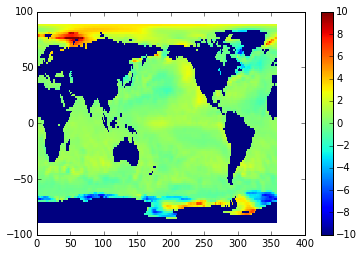

In [57]:
#resize to be the same shape as the data
meansstseas=np.tile(fixed_sstseas['skt'].values,(68,1,1))
np.shape(meansstseas)

anomsst = sstdata['skt'].values-meansstseas

plt.pcolormesh(sstdata['lon'].values,sstdata['lat'].values,anomsst[269,:,:])
plt.clim([-10,10])
plt.colorbar()

In [58]:
def seas_departure(inputarr,field):
    seas=inputarr.groupby('time.season').mean(dim='time')
    fixed_seas=xray.concat([seas.sel(season='DJF'),seas.sel(season='MAM'),\
             seas.sel(season='JJA'),seas.sel(season='SON')], 'season')
    #calculates the seasonal climatology but np.tile gives you back a numpy array
    mean_seas=np.tile(fixed_seas[field].values,(68,1,1))
    #put it back into an xray dataset
    #foo = xray.DataArray(data, coords=[times, locs], dims=['time', 'space'])
    mean_seas=xray.DataArray(mean_seas,coords=[inputarr['time'].values,inputarr['lat'].values,\
                                             inputarr['lon'].values],dims=['time','lat','lon'])
    anom = inputarr[field].values-mean_seas
    return anom

anomsst=seas_departure(sstdata,'skt')
anomsst

<xray.DataArray (time: 272, lat: 94, lon: 192)>
array([[[-4.44317245, -4.42129898, -4.42863083, ..., -4.36367035,
         -4.38543701, -4.41463852],
        [-3.66640091, -3.62452698, -3.5991745 , ..., -3.80857468,
         -3.74745941, -3.69694901],
        [-2.69404984, -2.68140411, -2.68823242, ..., -2.91536331,
         -2.82406235, -2.74878693],
        ..., 
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.24821091,  0.236166  ,  0.22953606, ...,  0.2504406 ,
          0.23942375,  0.23883057],
        [-0.18886185, -0.17407227, -0.17473221, ..., -0.18044281,
         -0.18090248, -0.18618202],
        [-0.53155708, -0.53410149, -0.55817604, ..., -0.47854424,
         -0.48344994, -0.49978828],
        ..., 
    

<matplotlib.colorbar.Colorbar instance at 0x7f26dd406b48>

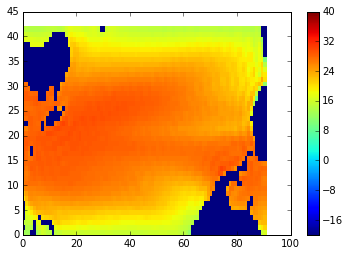

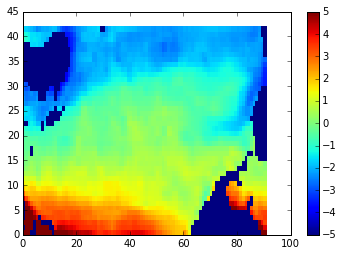

In [59]:
dsub = sstdata.sel(lat=slice(40,-40), lon=slice(120,290))
lat = dsub['lat'].values
lon = dsub['lon'].values

#calculate sst climatology
meansst=dsub['skt'].mean(axis=0)




plt.figure()
plt.pcolormesh(meansst.values)
plt.clim([-20,40])
plt.colorbar()

#resize to be the same shape as the data
meansst=np.tile(meansst.values.reshape(1,np.shape(meansst)[0],np.shape(meansst)[1]),(272,1,1))

#calculate anomalies
anomsst = dsub['skt'].values-meansst
lons, lats = np.meshgrid(lon, lat)

plt.figure()
plt.pcolormesh(anomsst[2,:,:])
plt.clim([-5,5])
plt.colorbar()



In [60]:
X = np.reshape(anomsst, (anomsst.shape[0], len(lat) * len(lon)), order='F')
X.shape

(272, 3822)

In [61]:
X = ma.masked_array(X, np.isnan(X))
land = X.sum(0).mask
ocean = -land
X = X[:,ocean]
X.shape

(272, 3356)

In [62]:
from sklearn import preprocessing
scaler  = preprocessing.StandardScaler()
scaler_sst = scaler.fit(X)
X = scaler_sst.transform(X)
from sklearn.decomposition import pca
skpca = pca.PCA()
skpca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

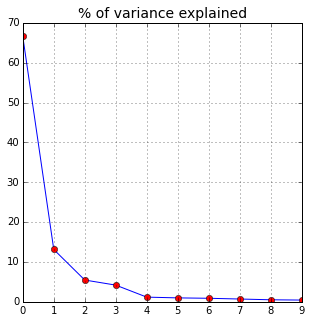

In [63]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

In [64]:
#get PCs
PCs = skpca.transform(X)
np.shape(PCs)
EOFs = skpca.components_
np.shape(EOFs)
ipc=272
EOF_recons = np.ones((ipc, len(lat) * len(lon))) * -999.
for i in range(ipc): 
    EOF_recons[i,ocean] = EOFs[i,:]
EOF_recons = ma.masked_values(np.reshape(EOF_recons, (ipc, len(lat), len(lon)), order='F'), -999.)
EOF_recons.shape

(272, 42, 91)

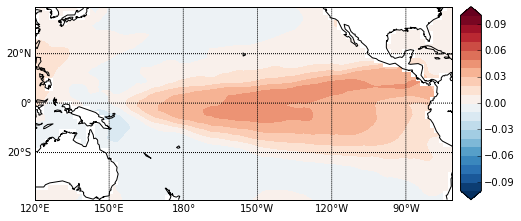

In [65]:
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 20), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)
        
m = bm(projection='cyl',llcrnrlat=lat.min(),urcrnrlat=lat.max(),\
            llcrnrlon=lon.min(),urcrnrlon=lon.max(),\
            lat_ts=0,resolution='c')



plot_field(m, EOF_recons[1,:,:], lats, lons, -.1, .1, .01, grid=True, cmap=plt.get_cmap('RdBu_r'))

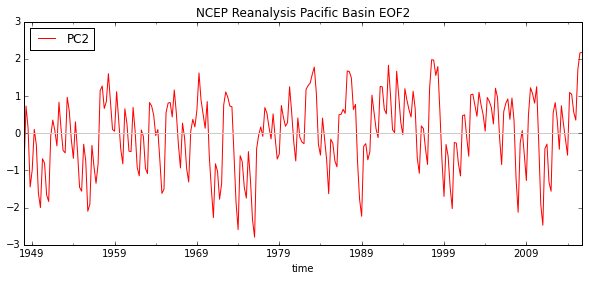

In [66]:
from sklearn.preprocessing import StandardScaler
scaler_PCs = StandardScaler()
scaler_PCs.fit(PCs)
PCs_std = scaler_PCs.transform(PCs)
PCdf = pd.DataFrame(PCs_std, index = dsub['time'], \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])
from scipy.signal import detrend
f, ax = plt.subplots(figsize=(10,4))
PCdf.ix[:,1].plot(ax=ax, color='r', label='PC2')
ax.axhline(0, c='0.8')
#ax.set_xlabel('period', fontsize=18)
#ax.plot(PCdf.index, detrend(PCdf.ix[:,1].values), 'r',  label='PC2 (trend removed)',linewidth=13)
plt.title('NCEP Reanalysis Pacific Basin EOF2 ')
ax.grid('off')
ax.legend(loc=2); 
plt.savefig('EOF2.svg')

(2) Create normalized index values (mean=0, sd=1) of Sea Level Pressure between Tahiti and Darwin similar to Fig. 4.  Invert the index (multiply by -1, as in the paper).  Plot the time series.

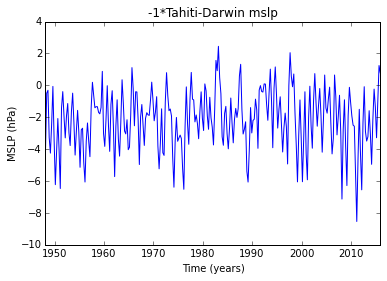

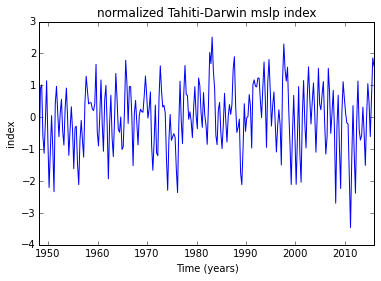

In [67]:
slp=xray.open_dataset('slp_seas_ncep.nc')
slp
tahitimslp = slp.sel(lat=-15., lon=360-149.,method='nearest')
tahitimslp

darwinmslp = slp.sel(lat=-12., lon=131.,method='nearest')
darwinmslp
plt.figure()
plt.plot(tahitimslp['time'].values,-1*(tahitimslp['slp'].values-darwinmslp['slp'].values))
plt.title('-1*Tahiti-Darwin mslp')
plt.ylabel('MSLP (hPa)')
plt.xlabel('Time (years)')

#calculate normalized index, with mean=0 and std=1
diff=-1*(tahitimslp['slp']-darwinmslp['slp'])
diff=(diff-np.mean(diff))
diff=diff/np.std(diff)
diff

plt.figure()
plt.plot(diff['time'].values,diff)
plt.title('normalized Tahiti-Darwin mslp index')
plt.ylabel('index')
plt.xlabel('Time (years)')


(3) Create normalized index values of 200 hPa height at the stations listed in Fig 6.  Plot the time series.

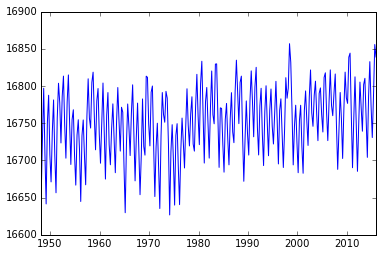

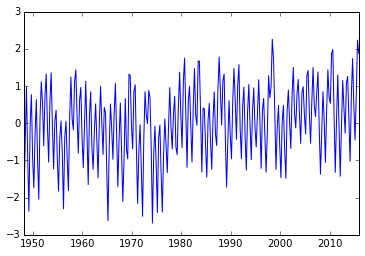

In [68]:
h200=xray.open_dataset('h200_seas_ncep.nc')

sites= ['NAI','DAR','NAN','HIL','SAJ']
lat=np.array([-1.2,-12.4,-17.5,  19.7, 18.0])
lon=np.array([36.8,130.0,177.0,-155.0,-66.0])

def grab_h200(h200,lat,lon):
    return h200.sel(lat=lat, lon=360-lon,method='nearest')


all_h200={}
for i in np.arange(len(lat)):
    all_h200[sites[i]]=grab_h200(h200,lat[i],lon[i])
    
z200index=0.2*all_h200['NAI']+0.23*all_h200['DAR']+0.23*all_h200['NAN']+0.25*all_h200['HIL']+0.27*all_h200['SAJ']

plt.plot(z200index['time'].values,z200index['hgt'].values)

def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)

z200index_std=standardize(z200index)
z200index_std

plt.figure()
plt.plot(z200index_std['time'].values,z200index_std['hgt'].values)

(4) Compute the PNA and WP indices as on p. 823 of the paper. Plot the time series.

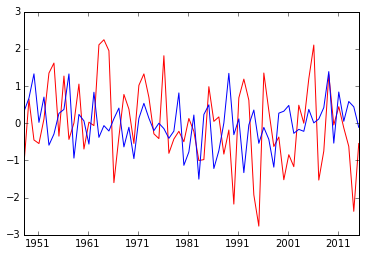

In [69]:
h700=xray.open_dataset('h700_seas_ncep.nc')

sites= ['S1','S2','S3','S4','S5']
lat=np.array([55.,45.,30.,  30., 60.])
lon=np.array([-115.,-165.,-85.,155.0,155.0])

def grab_h700(h700,lat,lon):
    return h700.sel(lat=lat, lon=360-lon,method='nearest')

def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)

all_h700={}
for i in np.arange(len(lat)):
    all_h700[sites[i]]=grab_h700(h700,lat[i],lon[i])
    all_h700[sites[i]]=all_h700[sites[i]].isel(time=np.arange(0,len(h700['time'].values),4))
    all_h700[sites[i]]=standardize(all_h700[sites[i]])
    
pnaindex=all_h700['S1']-0.5*(all_h700['S2']+all_h700['S3'])
wpindex=0.5*(all_h700['S4']+all_h700['S5'])



plt.figure()
plt.plot(h700['time'].values[::4],pnaindex['hgt'].values,'-r')
plt.plot(h700['time'].values[::4],wpindex['hgt'].values,'-b')

(5) Compute standardized rainfall values at the locations in Fig. 3. Plot the time series.

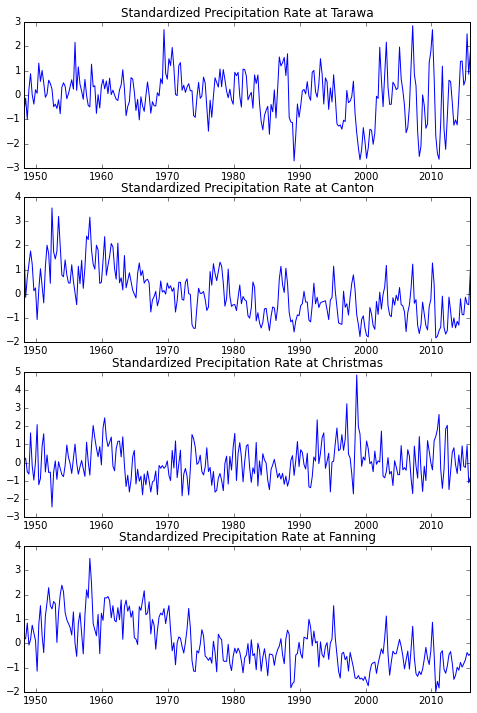

In [76]:
precip = xray.open_dataset('precip_seas_ncep.nc')
precip = seas_departure(precip,'prate')

tarawamslp = precip.sel(lat=1.4167,lon=173.0333,method='nearest')
tarawamslp = standardize(tarawamslp)
cantonmslp = precip.sel(lat=-2.8106,lon=360.-171.6756,method='nearest')
cantonmslp = standardize(cantonmslp)
christmasmslp = precip.sel(lat=-10.4833,lon=105.6333,method='nearest')
christmasmslp = standardize(christmasmslp)
fanningmslp = precip.sel(lat=3.86,lon=360.-159.3644,method='nearest')
fanningmslp = standardize(fanningmslp)

plt.figure(figsize=[8,12])
plt.subplot(4,1,1)
plt.plot(tarawamslp['time'],tarawamslp)
plt.title('Standardized Precipitation Rate at Tarawa')
plt.subplot(4,1,2)
plt.plot(cantonmslp['time'],cantonmslp)
plt.title('Standardized Precipitation Rate at Canton')
plt.subplot(4,1,3)
plt.plot(christmasmslp['time'],christmasmslp)
plt.title('Standardized Precipitation Rate at Christmas')
plt.subplot(4,1,4)
plt.plot(fanningmslp['time'],fanningmslp)
plt.title('Standardized Precipitation Rate at Fanning')

(6) Reproduce Fig 8 with the top 4 and bottom 4 values of PNA index (that you find in part 4), except contour the values you have rather than plot points as in the paper.

<matplotlib.colorbar.Colorbar instance at 0x7f26dd390320>

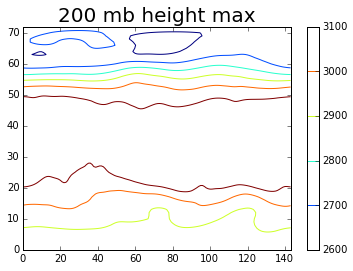

In [77]:
slp=xray.open_dataset('h700_seas_ncep.nc');
slp2=xray.open_dataset('h700_seas_ncep.nc');

PNAsort = np.sort(PNA)
Topvals =[PNAsort[-1],PNAsort[-2],PNAsort[-3],PNAsort[-4]]
max_time = [];

for i in range(len(Topvals)):
    k = np.where(PNA==Topvals[i])[0][0]
    max_time.append(slp['time'].values[k]);

istime = (max_time[0]==slp2['time'])
set1 = slp2['hgt'][istime,:,:]

istime = (max_time[1]==slp2['time'])
set2 = slp2['hgt'][istime,:,:]

istime = (max_time[2]==slp2['time'])
set3 = slp2['hgt'][istime,:,:]

istime = (max_time[3]==slp2['time'])
set4 = slp2['hgt'][istime,:,:]
max_set = (set1.values+set2.values+set3.values+set4.values)/4

plt.figure()
plt.contour(np.reshape((max_set),[73,144]));
plt.title('200 mb height max', fontsize=20)
plt.colorbar()

(7) Recreate Figure 9 using your data.

In [70]:
#200 hPa - 700 hPa correlation map

z200index_std['hgt']

h700=xray.open_dataset('h700_seas_ncep.nc')

print(np.shape(h700['hgt'].values))

def spatial_corr(index,mapvals):
    sz=np.shape(mapvals)
    
    outmap=np.zeros([sz[1],sz[2]])
    for i in np.arange(sz[1]):
        for j in np.arange(sz[2]):
            maptser=np.squeeze(mapvals[:,i,j])
            #print(np.shape(maptser))
            #print(np.shape(index))
            df_bis = pd.DataFrame({'maptser': maptser,
                       'index': np.squeeze(index)})
            outmap[i,j]=df_bis.corr().values[1,0]
            
    return outmap

(272, 73, 144)


In [71]:
h700['time']

<xray.DataArray 'time' (time: 272)>
array(['1948-02-29T00:00:00.000000000Z', '1948-05-31T00:00:00.000000000Z',
       '1948-08-31T00:00:00.000000000Z', '1948-11-30T00:00:00.000000000Z',
       '1949-02-28T00:00:00.000000000Z', '1949-05-31T00:00:00.000000000Z',
       '1949-08-31T00:00:00.000000000Z', '1949-11-30T00:00:00.000000000Z',
       '1950-02-28T00:00:00.000000000Z', '1950-05-31T00:00:00.000000000Z',
       '1950-08-31T00:00:00.000000000Z', '1950-11-30T00:00:00.000000000Z',
       '1951-02-28T00:00:00.000000000Z', '1951-05-31T00:00:00.000000000Z',
       '1951-08-31T00:00:00.000000000Z', '1951-11-30T00:00:00.000000000Z',
       '1952-02-29T00:00:00.000000000Z', '1952-05-31T00:00:00.000000000Z',
       '1952-08-31T00:00:00.000000000Z', '1952-11-30T00:00:00.000000000Z',
       '1953-02-28T00:00:00.000000000Z', '1953-05-31T00:00:00.000000000Z',
       '1953-08-31T00:00:00.000000000Z', '1953-11-30T00:00:00.000000000Z',
       '1954-02-28T00:00:00.000000000Z', '1954-05-31T00:00:00.00

In [78]:
outmap=spatial_corr(z200index_std['hgt'].values,h700['hgt'].values)

<matplotlib.colorbar.Colorbar instance at 0x7f26dbae60e0>

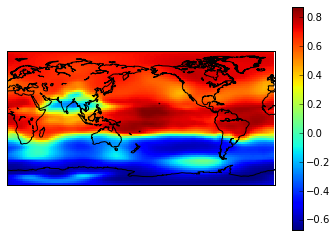

In [79]:

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup north polar stereographic basemap.
# The longitude lon_0 is at 6-o'clock, and the
# latitude circle boundinglat is tangent to the edge
# of the map at lon_0. Default value of lat_ts
# (latitude of true scale) is pole.
m = Basemap(lon_0=180)

m.pcolormesh(h700['lon'].values,h700['lat'].values,outmap)
m.drawcoastlines()
plt.colorbar()
